<a href="https://colab.research.google.com/github/sagarv2522/fifa-cluster/blob/main/Fifa_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering of FIFA Players ⚽🥅

## **Loading Data from cloud (Big Query)**

In [25]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated !')

Authenticated !


In [26]:
project_id = "my-project-data-247689"

In [27]:
import pandas as pd
data=pd.io.gbq.read_gbq('''
  SELECT short_name, overall, potential, value_eur, wage_eur, age
  FROM `my-project-data-247689.fifa_22.Fifa_players_22`
  ORDER BY overall DESC''',project_id=project_id, dialect='standard')

## **Processing the data**


In [82]:
#import the required library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from IPython.display import clear_output

In [29]:
#display the few rows
data.head()

,short_name,overall,potential,value_eur,wage_eur,age
0,L. Messi,93,93,78000000.0,320000.0,34
1,R. Lewandowski,92,92,119500000.0,270000.0,32
2,J. Oblak,91,93,112000000.0,130000.0,28
3,K. De Bruyne,91,91,125500000.0,350000.0,30
4,Cristiano Ronaldo,91,91,45000000.0,270000.0,36


In [30]:
#check the missing values
data.isna().sum()

short_name     0
overall        0
potential      0
value_eur     74
wage_eur      61
age            0
dtype: int64

In [31]:
#drop the short_name columns and missing values
players = data.drop('short_name',axis=1)
players = players.dropna(axis=0)
players.head()

,overall,potential,value_eur,wage_eur,age
0,93,93,78000000.0,320000.0,34
1,92,92,119500000.0,270000.0,32
2,91,93,112000000.0,130000.0,28
3,91,91,125500000.0,350000.0,30
4,91,91,45000000.0,270000.0,36


In [32]:
#recheck their is any missing values
players.isna().sum()

overall      0
potential    0
value_eur    0
wage_eur     0
age          0
dtype: int64

## **Steps for K-Means Model**

*   scale the data
*   specify the number of clusters
*   initilize the centroid random
*   calculate the equlidean distance
*   then calculate the equlidean mean
*   repeat the 3 to 5 steps





In [34]:
#scaling our data from 1 to 7
players = ((players - players.min())/(players.max() - players.min()))*6 + 1
players.describe()

,overall,potential,value_eur,wage_eur,age
count,19165.0,19165.0,19165.000000,19165.000000,19165.0
mean,3.446981,3.879999,1.087884,1.146296,3.04223
std,0.897757,0.794051,0.235486,0.334352,1.050559
min,1.0,1.0,1.000000,1.000000,1.0
25%,2.826087,3.347826,1.014413,1.008584,2.111111
50%,3.478261,3.869565,1.029878,1.042918,3.0
75%,4.0,4.391304,1.061580,1.128755,3.888889
max,7.0,7.0,7.000000,7.000000,7.0


In [44]:
def random_centroid(data, k:int):
  '''Generate a random centroid for the cluster

  Args: data- pd.dataframe
        k - int

  Return: centroids - pd.dataframe'''
  centroid = []
  for i in range(k):
    values=data.apply(lambda x: float(x.sample()))
    centroid.append(values)
  return pd.concat(centroid, axis=1)

In [46]:
centroids = random_centroid(players, 5)
centroids

,0,1,2,3,4
overall,3.869565,4.391304,2.826087,4.130435,1.521739
potential,2.826087,4.521739,4.652174,4.000000,3.869565
value_eur,1.030651,1.049208,1.015186,1.049208,1.015960
wage_eur,1.000000,1.025751,1.025751,1.042918,1.231760
age,2.555556,2.777778,3.444444,2.111111,1.666667


In [65]:
def get_labels(data, centroid):
  '''Calculating the labels for a each data point'''
  distance = centroid.apply(lambda x: (np.sqrt(((data - x)**2).sum(axis=1))))
  return distance.idxmin(axis=1)

In [75]:
labels = get_labels(players, centroids)
labels.value_counts()

1    5801
0    4667
4    3248
3    3210
2    2239
dtype: int64

In [86]:
def new_centroid(data, labels, k):
  '''Getting new centroid for the clusters'''
  return data.groupby(labels).apply(lambda x:(np.exp(np.log(x).mean()))).T

In [81]:
new_centroid(players, labels)

,0,1,2,3,4
overall,3.082096,4.411816,3.564908,3.311461,2.121646
potential,3.078651,4.531224,3.446643,4.300231,3.530594
value_eur,1.019402,1.199624,1.020462,1.045190,1.010930
wage_eur,1.033890,1.334706,1.061064,1.051563,1.012655
age,3.336380,3.262528,4.438906,2.119828,1.794650


In [88]:
def plot_clusters(data, labels, centroids, iteration):
  '''
  * Transforming the 5D data into 2d data with the help of PCA
  * Plotting the graph for a each iteration step and clear the output

  Args: data-pd.dataframe,
        labels-array,
        centroids-pd.dataframe,
        iteration-int

  Return: line graph
  '''
  pca = PCA(n_components=2)
  data_2d = pca.fit_transform(data)
  centroid_2d = pca.transform(centroids.T)
  clear_output(wait=True)
  plt.title(f'Iteration {iteration}')
  plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
  plt.scatter(x=centroid_2d[:,0], y=centroid_2d[:,1])
  plt.show()

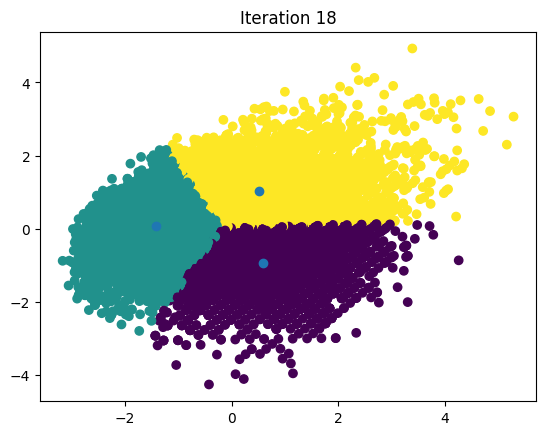

In [113]:
max_iter = 100
k = 3
centroid = random_centroid(players, k)
old_centroid = pd.DataFrame()
iter = 1

while iter < max_iter and not centroid.equals(old_centroid):
  old_centroid=centroid
  labels = get_labels(players, centroid)
  centroid = new_centroid(players, labels, k)
  plot_clusters(players, labels, centroid, iter)
  iter += 1

In [90]:
centroid

,0,1,2
overall,3.530083,4.219070,2.494350
potential,3.343842,4.671077,3.630739
value_eur,1.030114,1.200475,1.018047
wage_eur,1.081168,1.297526,1.019370
age,3.992032,2.754033,2.028328


## **Another Method(comman method)**

In [91]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

In [94]:
num_cluster = [i for i in range(2, 11)]

def kms_inertia(num_cluster, data):
  """
    Accepts as arguments list of ints and data array.
    Fits a KMeans model where k = each value in the list of ints.
    Returns each k-value's inertia appended to a list.
    """
  inertia=[]
  for num in num_cluster:
    kms = KMeans(n_clusters=num, random_state=42)
    kms.fit(data)
    inertia.append(kms.inertia_)
  return inertia

In [98]:
inertia = kms_inertia(num_cluster, players)
inertia

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

[33010.33399342388,
 22961.69740206933,
 18631.640645609274,
 15637.558538612375,
 13563.06667148523,
 11789.992214936321,
 10602.653318657969,
 9618.885439842494,
 8767.24247335543]

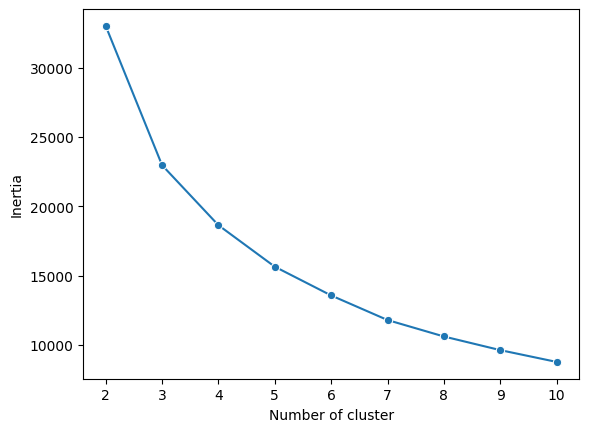

In [99]:
fig=sns.lineplot(x=num_cluster, y=inertia, marker='o')
fig.set_xlabel('Number of cluster')
fig.set_ylabel('Inertia')
plt.show()

In [108]:
def kms_sill(num_cluster, data):
  """
    Accepts as arguments list of ints and data array.
    Fits a KMeans model where k = each value in the list of ints.
    Calculates a silhouette score for each k value.
    Returns each k-value's silhouette score appended to a list.
    """
  sill_score=[]
  for num in num_cluster:
    kms =KMeans(n_clusters=num, random_state=42)
    kms.fit(data)
    sill_score.append(silhouette_score(data, kms.labels_))
  return sill_score

In [109]:
sill_score = kms_sill(num_cluster, players)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

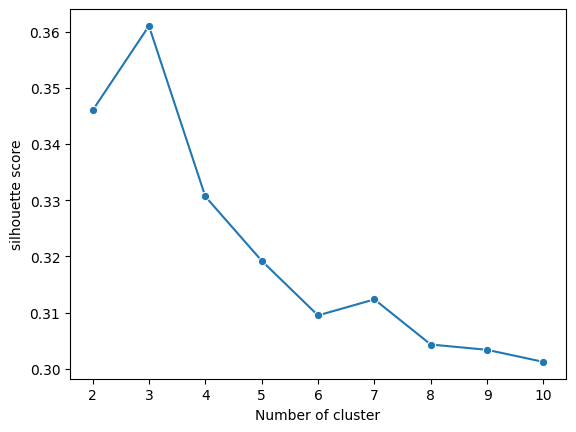

In [110]:
fig= sns.lineplot(x=num_cluster, y=sill_score, marker='o')
fig.set_xlabel('Number of cluster')
fig.set_ylabel('silhouette score')
plt.show()

## optimising the K value as 3

In [111]:
kms3 = KMeans(n_clusters=3, random_state=42)
kms3.fit(players)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [112]:
print('Unique labels:', np.unique(kms3.labels_))

Unique labels: [0 1 2]


In [119]:
pd.DataFrame(kms3.cluster_centers_, columns=players.columns).T

,0,1,2
overall,2.733240,4.487417,3.534125
potential,3.803913,4.749293,3.336102
value_eur,1.023861,1.275829,1.026684
wage_eur,1.026631,1.438076,1.075312
age,2.141590,3.093040,4.072784
